In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoImageProcessor, CvtForImageClassification, AutoConfig
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image, UnidentifiedImageError
import os
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import seaborn as sns


In [72]:
# Tentukan device untuk training (GPU jika tersedia)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [73]:
# Hyperparameters dan paths
BATCH_SIZE = 32
NUM_CLASSES = 20
EPOCHS = 20
LEARNING_RATE = 0.0001
WEIGHT_DECAY = 0.00001
IMAGE_SIZE = 224
DATASET_PATH = '/kaggle/input/d/phiard/aksara-jawa/v3/v3'


In [74]:
# Load dan konfigurasi model CvT-13
config = AutoConfig.from_pretrained("microsoft/cvt-13")
config.num_labels = NUM_CLASSES
config.hidden_dropout_prob = 0.01
image_processor = AutoImageProcessor.from_pretrained("microsoft/cvt-13")
model = CvtForImageClassification.from_pretrained(
    "microsoft/cvt-13", config=config, ignore_mismatched_sizes=True
).to(device)

Some weights of CvtForImageClassification were not initialized from the model checkpoint at microsoft/cvt-13 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([20]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([20, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [75]:
from torchvision import transforms

# Transformasi untuk data training
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),            # Flipping horizontal acak
    transforms.RandomRotation(20),                # Rotasi acak antara -20 hingga 20 derajat
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.8, 1.0)),  # Crop acak dengan ukuran tertentu
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Variasi warna
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalisasi
])

# Transformasi untuk data validasi (tanpa augmentasi)
val_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),               # Resize gambar untuk validasi
    transforms.CenterCrop(IMAGE_SIZE),           # Crop di tengah
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalisasi
])

# CustomImageFolder dengan transformasi yang telah diubah
class CustomImageFolder(Dataset):
    def __init__(self, root, transform=None):
        self.samples = []
        self.targets = []
        self.transform = transform
        classes, class_to_idx = self._find_classes(root)
        self.class_to_idx = class_to_idx
        self.classes = classes

        for target_class in sorted(class_to_idx.keys()):
            class_index = class_to_idx[target_class]
            target_dir = os.path.join(root, target_class)
            if not os.path.isdir(target_dir):
                continue
            for root_, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
                for fname in sorted(fnames):
                    path = os.path.join(root_, fname)
                    try:
                        with Image.open(path) as img:
                            img.verify()
                        self.samples.append((path, class_index))
                        self.targets.append(class_index)
                    except (UnidentifiedImageError, OSError):
                        print(f"Gambar korup dilewati: {path}")
                        continue

    def __getitem__(self, index):
        path, target = self.samples[index]
        with Image.open(path) as sample:
            sample = sample.convert('RGB')
        
        # Apply transformation
        if self.transform:
            sample = self.transform(sample)
        
        return sample, target

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        path, target = self.samples[index]
        with Image.open(path) as sample:
            sample = sample.convert('RGB')
        inputs = image_processor(images=sample, return_tensors="pt")
        return inputs["pixel_values"].squeeze(0), target

    def _find_classes(self, dir):
        classes = [d.name for d in os.scandir(dir) if d.is_dir()]
        classes.sort()
        class_to_idx = {classes[i]: i for i in range(len(classes))}
        return classes, class_to_idx


In [76]:
# Load dataset dan lakukan pembagian 80/20
train_dataset = CustomImageFolder(os.path.join(DATASET_PATH, 'train'))
val_dataset = CustomImageFolder(os.path.join(DATASET_PATH, 'val'))

# Pembagian test dataset ke training dan validation 80/20
train_size = int(0.8 * len(train_dataset))
test_size = len(train_dataset) - train_size
train_dataset, test_dataset = random_split(train_dataset, [train_size, test_size])

# Membuat DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [77]:
# Hitung class weights untuk ketidakseimbangan kelas
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_dataset.dataset.targets),
    y=train_dataset.dataset.targets
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)


In [78]:
# Loss function
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.05)

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=10)


In [79]:
# Fungsi train
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        output = model(data).logits
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = output.max(1)
        correct += predicted.eq(target).sum().item()
        total += target.size(0)
    return total_loss / len(loader), 100. * correct / total


In [80]:
# Fungsi validasi
def validate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_targets = []
    all_predictions = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data).logits
            loss = criterion(output, target)
            total_loss += loss.item()
            _, predicted = output.max(1)
            correct += predicted.eq(target).sum().item()
            total += target.size(0)
            all_targets.extend(target.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    f1 = f1_score(all_targets, all_predictions, average='weighted')
    return total_loss / len(loader), 100. * correct / total, f1, all_targets, all_predictions


In [81]:
# Training loop
writer = SummaryWriter()
best_val_acc = 0
train_losses, train_accs, val_losses, val_accs, val_f1_scores = [], [], [], [], []

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc, val_f1, all_targets, all_predictions = validate(model, val_loader, criterion)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_f1_scores.append(val_f1)

    writer.add_scalars('Loss', {'Train': train_loss, 'Val': val_loss}, epoch)
    writer.add_scalars('Accuracy', {'Train': train_acc, 'Val': val_acc}, epoch)
    writer.add_scalar('F1_Score/Val', val_f1, epoch)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_cvt_model.pth")
    
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val F1 Score: {val_f1:.4f}")

    scheduler.step()

writer.close()


Epoch 1/20
Train Loss: 2.8651, Train Acc: 12.94%
Val Loss: 3.0744, Val Acc: 7.08%, Val F1 Score: 0.0380
Epoch 2/20
Train Loss: 2.3104, Train Acc: 34.24%
Val Loss: 3.1154, Val Acc: 7.08%, Val F1 Score: 0.0425
Epoch 3/20
Train Loss: 1.7226, Train Acc: 58.44%
Val Loss: 1.7924, Val Acc: 49.17%, Val F1 Score: 0.4495
Epoch 4/20
Train Loss: 1.3578, Train Acc: 69.36%
Val Loss: 1.4716, Val Acc: 57.50%, Val F1 Score: 0.5563
Epoch 5/20
Train Loss: 1.1736, Train Acc: 73.82%
Val Loss: 1.0380, Val Acc: 75.62%, Val F1 Score: 0.7492
Epoch 6/20
Train Loss: 1.0067, Train Acc: 78.76%
Val Loss: 0.8609, Val Acc: 81.88%, Val F1 Score: 0.8184
Epoch 7/20
Train Loss: 1.0199, Train Acc: 77.60%
Val Loss: 0.8483, Val Acc: 83.54%, Val F1 Score: 0.8257
Epoch 8/20
Train Loss: 0.9829, Train Acc: 78.35%
Val Loss: 0.7926, Val Acc: 82.92%, Val F1 Score: 0.8280
Epoch 9/20
Train Loss: 0.9793, Train Acc: 78.12%
Val Loss: 0.8152, Val Acc: 81.67%, Val F1 Score: 0.8131
Epoch 10/20
Train Loss: 0.9215, Train Acc: 80.50%
Val Los

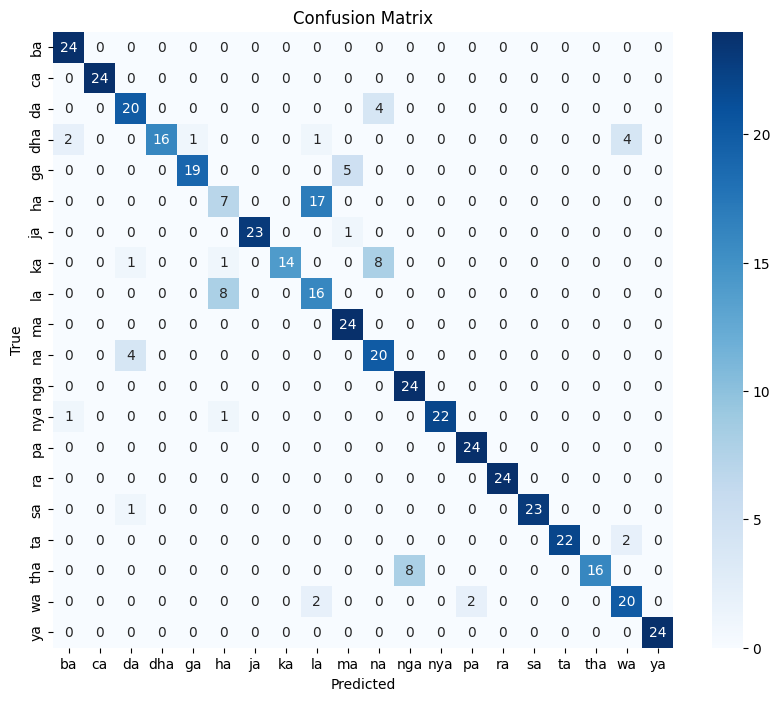

In [82]:
# Plot confusion matrix
def plot_confusion_matrix(targets, predictions, class_names):
    cm = confusion_matrix(targets, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(all_targets, all_predictions, train_dataset.dataset.classes)


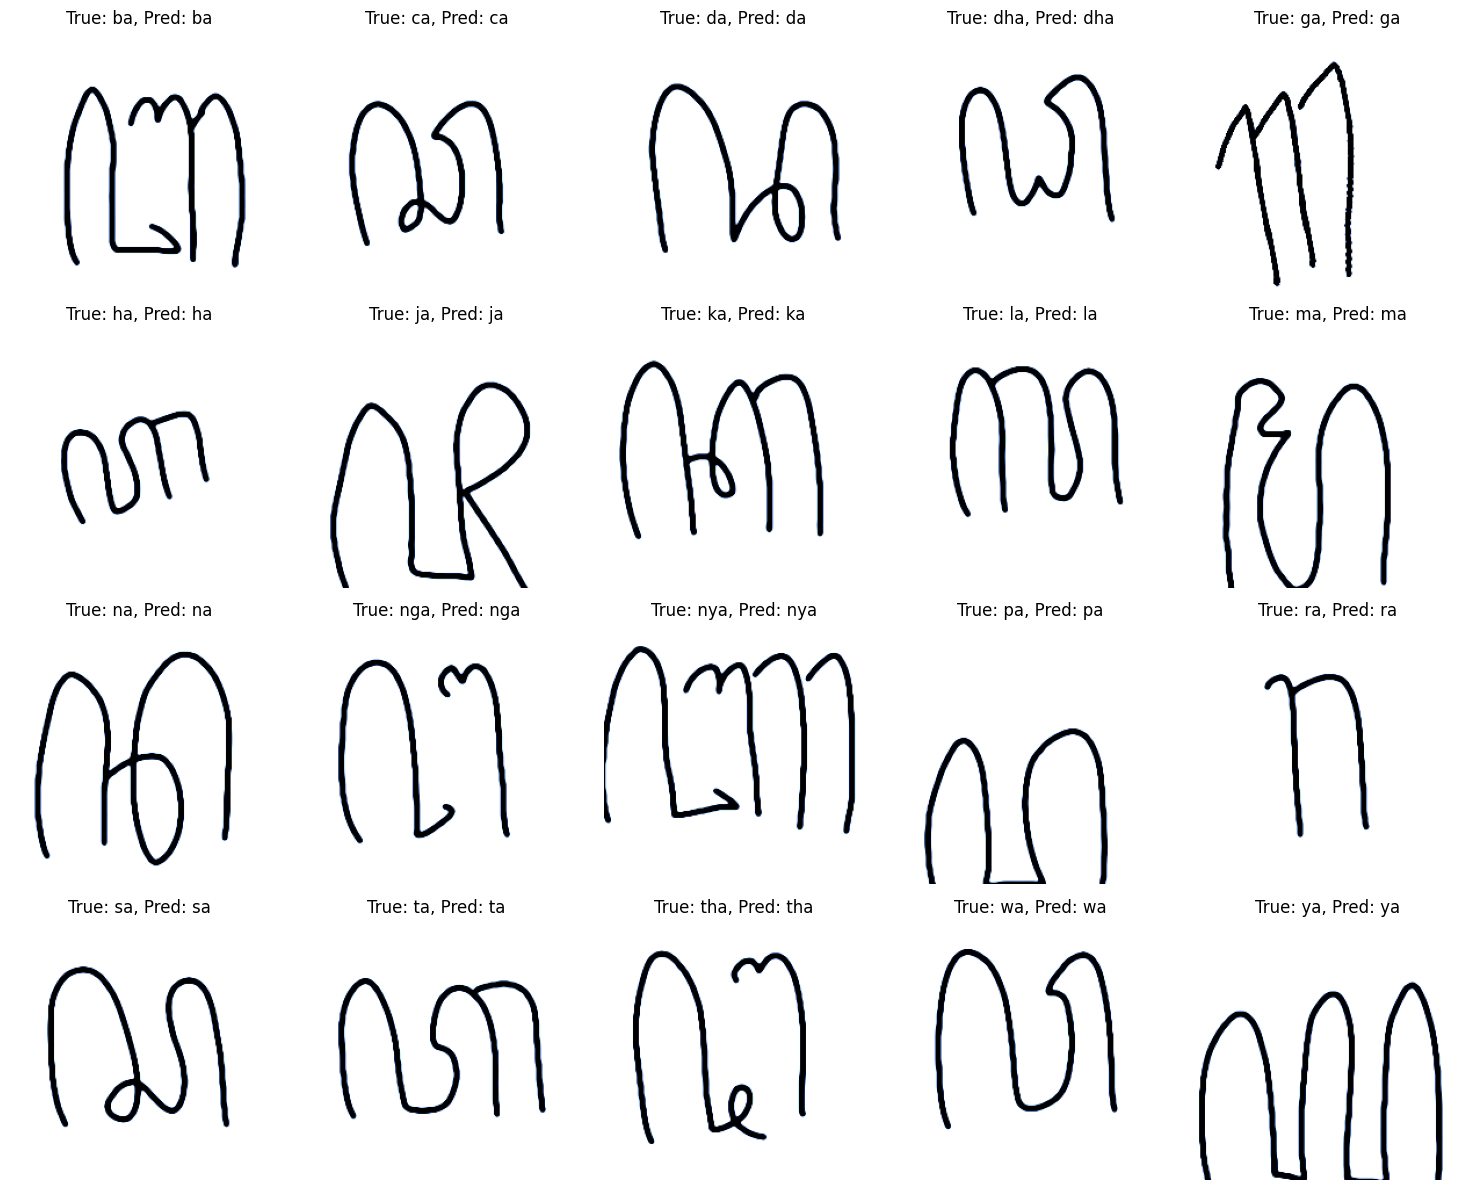

In [83]:
# Fungsi untuk menampilkan gambar per kelas dengan prediksi model
def show_predictions_per_class(model, dataset, num_classes=20, cols=5):
    model.eval()
    rows = (num_classes + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    axs = axs.flatten()

    class_images = {i: None for i in range(num_classes)}

    for i in range(len(dataset)):
        image, label = dataset[i]
        image = image.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(image).logits
            _, predicted = output.max(1)
            if class_images[label] is None and predicted.item() == label:
                class_images[label] = (image.squeeze().cpu(), label, predicted.item())
                if all(value is not None for value in class_images.values()):
                    break

    for i in range(num_classes):
        ax = axs[i]
        if class_images[i] is not None:
            img, true_label, pred_label = class_images[i]
            ax.imshow(img.permute(1, 2, 0).numpy())
            ax.set_title(f"True: {train_dataset.dataset.classes[true_label]}, Pred: {train_dataset.dataset.classes[pred_label]}")
            ax.axis('off')
        else:
            ax.text(0.5, 0.5, 'No Prediction', ha='center', va='center')
            ax.axis('off')

    for j in range(num_classes, rows * cols):
        axs[j].axis('off')
    
    plt.tight_layout()
    plt.show()

show_predictions_per_class(model, val_dataset)


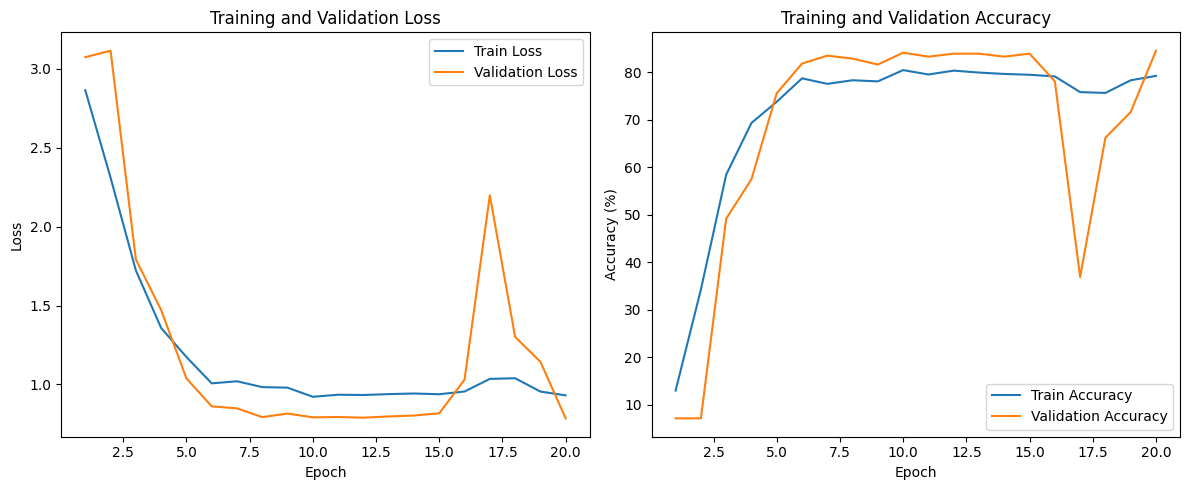

In [84]:
# Plotting Training and Validation Loss and Accuracy
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Train Accuracy')
plt.plot(range(1, len(val_accs) + 1), val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
